In [50]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *
from SystematicsHelpers import *

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

import pyhf
from pyhf.contrib.viz import brazil

pyhf.set_backend("numpy")

In [51]:
savePath = "../plot_files/06April2024_m200_v3_sensitivity/"

<h1> Read in HNL Dictionary </h1>

In [52]:
nu_dict = np.load("../pkl_files/v3_April2024/nu_m"+str(m)+"_v3_weight.npy",allow_pickle='TRUE').item()

In [53]:
hnl_dict = {}
mass_list = [200]

for m in mass_list:
    hnl_dict[m] = np.load("../pkl_files/v3_April2024/hnl_m"+str(m)+"_v3_weight.npy",allow_pickle='TRUE').item()

In [54]:
hnl_dict[200].keys()

dict_keys(['cv', 'cv_plot', 'bins', 'bins_mid', 'stat_cov', 'stat_err', 'flx_cov', 'flx_err', 'combined_cov', 'stat_cov_frac', 'stat_frac_err', 'flx_cov_frac', 'flx_frac_err', 'combined_err', 'combined_cov_frac', 'combined_frac_err', 'cv_scale', 'cv_plot_scale', 'combined_cov_scale', 'stat_cov_scale', 'stat_err_scale', 'stat_cov_frac_scale', 'stat_frac_err_scale', 'flx_cov_scale', 'flx_err_scale', 'flx_cov_frac_scale', 'flx_frac_err_scale', 'combined_err_scale', 'combined_cov_frac_scale', 'combined_frac_err_scale', 'm', 'fitU'])

In [55]:
signal = hnl_dict[200]['cv_scale'].tolist()
bkg = nu_dict['cv_scale'].tolist()

signal_stat = hnl_dict[200]['stat_err_scale'].tolist()
bkg_stat = nu_dict['stat_err_scale'].tolist()

In [63]:
test_data = nu_dict['stat_err_scale'] + 5
test_data = test_data.tolist()
print(len(test_data))
print(test_data)

19
[5.0, 27.16498266245211, 14.559628271060491, 14.559628271060491, 43.3610369708159, 63.73677055505178, 78.63390718145168, 92.6794244837388, 110.21479895045819, 105.43507565081903, 95.60485811242594, 71.23115172642245, 63.31012586469784, 45.27751682539054, 40.52706462213788, 18.51935595217901, 14.559628271060491, 16.708105697391378, 11.759677976089504]


<h1>Only Statistics Uncertainty</h1>

In [60]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": signal,
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "signal_stat", "type": "shapesys", "data":signal_stat },
              ]
            },
            {
              "name": "background",
              "data": bkg,
              "modifiers": [
                {"name": "bkg_stat", "type": "shapesys", "data": bkg_stat},
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

# No DATA --> Data == Background
#TODO --> Add statistical  uncertainty to data??
data = test_data + model_dict.config.auxdata

Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_stat', 'shapesys')]


In [61]:
print(data)

[5.0, 27.16498266245211, 14.559628271060491, 14.559628271060491, 43.3610369708159, 63.73677055505178, 78.63390718145168, 92.6794244837388, 110.21479895045819, 105.43507565081903, 95.60485811242594, 71.23115172642245, 63.31012586469784, 45.27751682539054, 40.52706462213788, 18.51935595217901, 14.559628271060491, 16.708105697391378, 11.759677976089504, 1.0, 1.0, 1.9999999999999998, 1.9999999999999998, 17.232494822980776, 59.66010382949428, 119.47958853783115, 172.47680491636774, 283.0305728276621, 280.7971243759911, 180.4791094626236, 93.59495222177578, 66.2878766354763, 20.709893342912263, 12.84567141405124, 4.0, 1.9999999999999998, 3.0000000000000004, 1.0, 588.0000000000001, 559.0, 457.00000000000006, 428.00000000000006, 394.00000000000006, 349.0, 376.0, 508.0000000000001, 699.9999999999999, 989.9999999999999, 1367.0, 1691.9999999999998, 1892.0000000000002, 1787.0000000000002, 1536.0000000000002, 1178.0, 985.0, 793.9999999999999, 617.0000000000001]


In [62]:
poi_values = np.linspace(0, 0.1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

EXP_LIMIT = np.sqrt(exp_limits_single[2]) * hnl_dict[200]['fitU']
LIMIT = np.sqrt(obs_limit_single) * hnl_dict[200]['fitU']

print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

quadSumUncorr = EXP_LIMIT

     fun: inf
     jac: array([-inf,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan])
 message: 'Inequality constraints incompatible'
    nfev: 40
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])
Traceback (most recent call last):
  File "/home/php19vcn/miniconda3/envs/rootenv/lib/python3.9/site-packages/pyhf/optimize/mixins.py", line 63, in _internal_minimize
    assert result.success
AssertionError


FailedMinimization: Inequality constraints incompatible

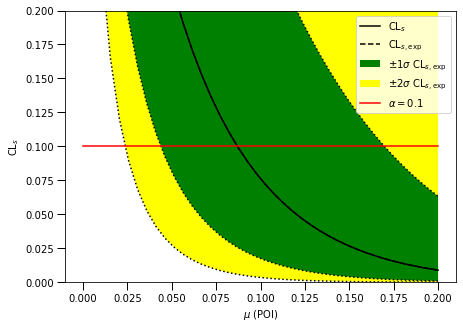

In [27]:
poi_vals = np.linspace(0, 0.2, 40)

results = [
    pyhf.infer.hypotest(
        test_poi, data, model_dict, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax, test_size=0.10,)
plt.ylim(0.0,0.2)
fig.show()

In [ ]:
for m in mass_list:
    print(hnl_dict[m]['U'])

<h1>Plot</h1>

In [ ]:
neg2sigma = []
neg1sigma = []
expect = []
pos1sigma = []
pos2sigma = []

for m in mass_list:
    neg2sigma.append(hnl_dict[m]['Limits'][0])
    neg1sigma.append(hnl_dict[m]['Limits'][1])
    expect.append(hnl_dict[m]['Limits'][2])
    pos1sigma.append(hnl_dict[m]['Limits'][3])
    pos2sigma.append(hnl_dict[m]['Limits'][4])
    

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(6,4))

xlimmin = 140
xlimmax = 240

plt.grid(axis = 'both', color='gainsboro', linestyle = ":")
#-------------------------------------------------------------------
ax1.plot(mass_list, neg2sigma, color = 'black', linestyle = ':')
ax1.plot(mass_list, neg1sigma, color = 'black', linestyle = ':')
ax1.plot(mass_list, pos1sigma, color = 'black', linestyle = ':')
ax1.plot(mass_list, pos2sigma, color = 'black', linestyle = ':')


ax1.scatter(mass_list, expect, color = 'black', linestyle = '-', label = r'CL$_{s, expected}$')
ax1.scatter(mass_list, 8.371627933396566e-09)
#-------------------------------------------------------------------

 
ax1.fill_between(mass_list, neg2sigma, pos2sigma, color = 'yellow', label = r'$\pm 2 \sigma$ CL$_{s}$')
ax1.fill_between(mass_list, neg1sigma, pos1sigma, color = 'green', label = r'$\pm 1 \sigma$ CL$_{s}$')   

#-------------------------------------------------------------------
#plt.xlim(180, 220)
plt.ylim(1e-9, 1e-6)
ax1.set_yscale('log')

plt.legend(loc="upper right", fontsize =14)

ax1.set_xlabel( "HNL Mass [MeV]", fontsize =14)
ax1.set_ylabel("|U$_{\mu4}$|$^2$", fontsize =14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#-------------------------------------------------------------------
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("sensitivity_test.png"), dpi=200)
plt.show()